In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data_path = join('./data', 'train.csv')
sub_data_path = join('./data', 'test.csv')

---
## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
y = data['price']

del data['price'] #학습을 위해 타깃정보 제외

In [5]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [6]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


---
## 2. 데이터 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>

In [7]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [8]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

### 변수 추가
기존 변수들을 활용하여 모델학습에 사용할 새로운 변수들을 만듭니다.<br>
변수 추가와 이상치 처리의 코드는 [캐글 게시글](https://www.kaggle.com/ta3gye0ng/brutal-force-for-newb)을 참고하였습니다

In [9]:
def feature(x):
    x['whether_to_renovated']=(x.yr_renovated!=0).astype(int)
    x.loc[x.yr_renovated==0,'yr_renovated']=x[x.yr_renovated==0].yr_built
    x.drop(['yr_built'],axis=1)
    x['garret']=(x.floors%1==0.5).astype(int)
    x.loc[x.floors%1==0.5,'floors']=np.floor(x[x.floors%1==0.5].floors)

    x['living_per_floors']=x['sqft_living']/x['floors']
    x['total_score']=x['condition']+x['grade']+x['view']
    x['living_per_lot']=x['sqft_living']/x['sqft_lot']
    x['diff_of_rooms']=np.abs(x['bedrooms']-x['bathrooms'])
    x['diff_lots']=np.abs(x['sqft_lot15']-x['sqft_lot'])
    x['diff_living']=np.abs(x['sqft_living15']-x['sqft_living'])
    x['diff_living_per_floor']=(x.sqft_living15-x.sqft_living)/x.floors
    x['exist_special']=x.garret+x.waterfront+x.whether_to_renovated

    return x

data=feature(data)
data.shape

(21503, 29)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

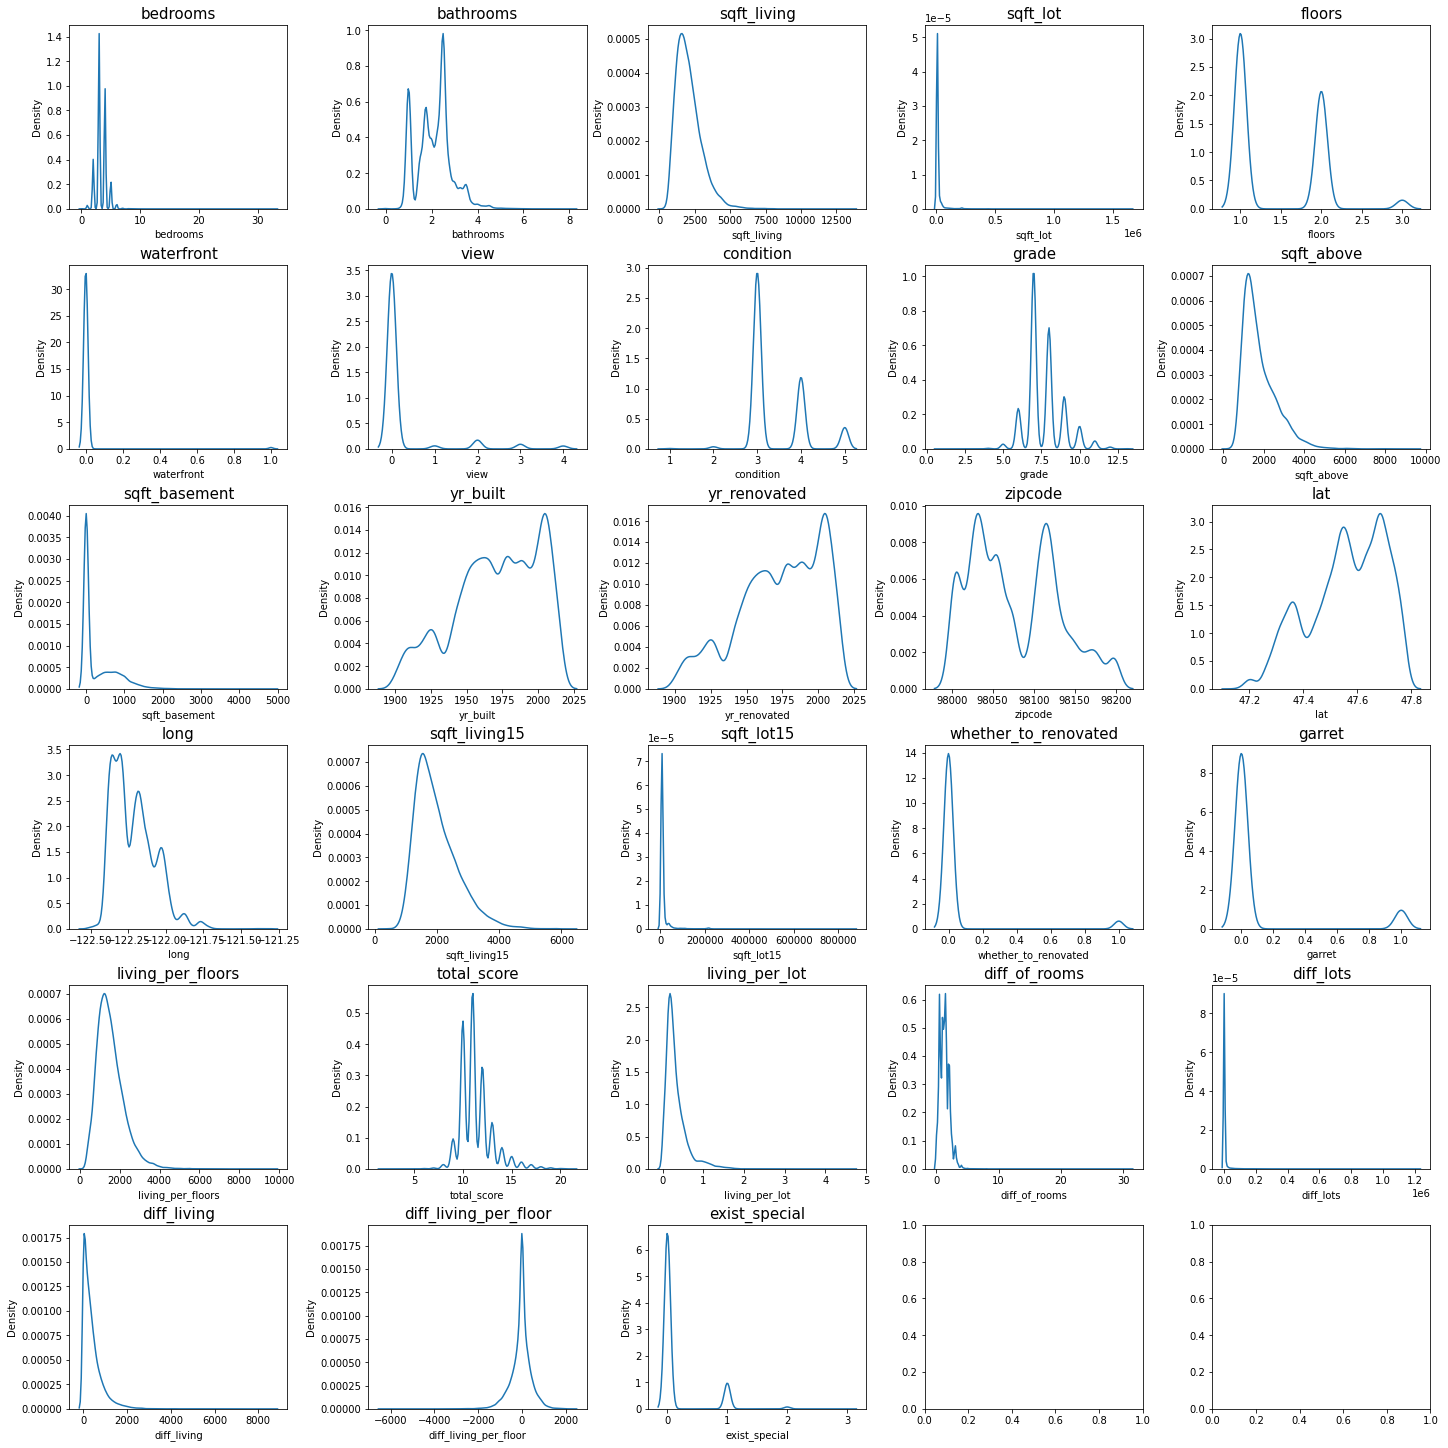

In [10]:
fig, ax = plt.subplots(6, 5, figsize=(20, 20), constrained_layout=True)

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(6):
    for col in range(5):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 29 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [11]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
                'sqft_lot15', 'sqft_living15','living_per_floors','diff_lots','diff_living']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)
    


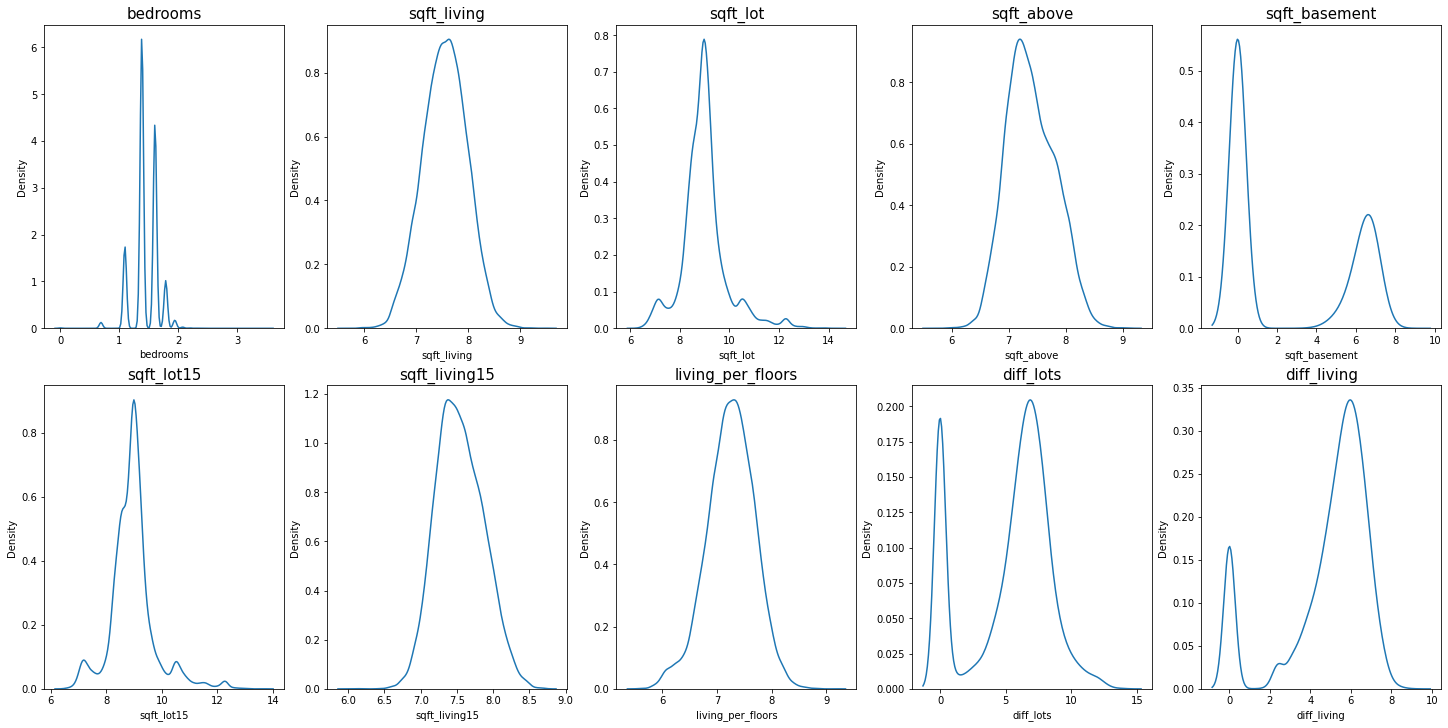

In [12]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10),constrained_layout=True)

count = 0
for row in range(2):
    for col in range(5):
        if count == 10:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [13]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 29)
(6468, 29)


---
## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [14]:
random_state=2020 

rdforest = RandomForestRegressor(random_state=random_state)
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(random_state=random_state)

### GridSearch
GridSearch를 통해 최적의 하이퍼파라미터 값을 찾아냅니다.

In [15]:
def my_GridSearch(model, train, y, param_grid, verbose=1):
    # 1. GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose)
    
    # 2. 모델 fitting
    grid_model.fit(train, y)

    # 3. 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 4. 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # 5. RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results


1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.


### RandomForest

In [16]:
rdforest_grid = { #학습시간이 너무 오래 걸려 임의의 값을 넣었습니다.
    'max_depth': [1],
    'n_estimators': [1],
    'min_samples_leaf': [2],
    'min_samples_split': [2]
}

result = my_GridSearch(rdforest, x.values, y, rdforest_grid)
result.head()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,max_depth,min_samples_leaf,min_samples_split,n_estimators,score,RMSLE
0,1,2,2,1,-9.626704e+10,310269.309853


In [17]:
#실제로 쓰여질 파라미터값은 이전 grid search를 통해 구한 값들입니다.
rdforest = RandomForestRegressor(max_depth=10,min_samples_leaf=2,min_samples_split=2,
                                 n_estimators=600,random_state=random_state)


### GradientBoosting

In [18]:
gboost_grid = {
    'max_depth' : [1,7], 
    'n_estimators': [100,500], 
    'learning_rate':[0.1,0.3]
}

result = my_GridSearch(gboost, x.values, y, gboost_grid)
result

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
3,0.1,7,500,-1.525736e+10,123520.673723
2,0.1,7,100,-1.556967e+10,124778.472994
6,0.3,7,100,-1.685311e+10,129819.509483
7,0.3,7,500,-1.688506e+10,129942.531102
5,0.3,1,500,-2.615324e+10,161719.628603
1,0.1,1,500,-2.748887e+10,165797.679517
4,0.3,1,100,-3.109100e+10,176326.387952
0,0.1,1,100,-3.535747e+10,188035.810596


In [19]:
gboost = GradientBoostingRegressor(learning_rate=0.1,max_depth=7,
                                   n_estimators=500, random_state=random_state)


### XGBoost

In [20]:
xgboost_grid = {
    'max_depth': [1,7], 
    'n_estimators': [100,500], 
    'learning_rate':[0.2,0.3], 
    'gamma': [1,2]
}

result = my_GridSearch(xgboost, x.values, y, xgboost_grid)
result

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,gamma,learning_rate,max_depth,n_estimators,score,RMSLE
2,1,0.2,7,100,-1.539793e+10,124088.405040
10,2,0.2,7,100,-1.539793e+10,124088.405040
3,1,0.2,7,500,-1.541837e+10,124170.715117
11,2,0.2,7,500,-1.541837e+10,124170.715117
6,1,0.3,7,100,-1.711292e+10,130816.357527
14,2,0.3,7,100,-1.711292e+10,130816.357527
7,1,0.3,7,500,-1.716238e+10,131005.272446
15,2,0.3,7,500,-1.716238e+10,131005.272446
5,1,0.3,1,500,-2.678143e+10,163650.322559
13,2,0.3,1,500,-2.678143e+10,163650.322559


In [21]:
xgboost = xgb.XGBRegressor(gamma=1.0,learning_rate=0.2,max_depth=5,
                           n_estimators=32, random_state=random_state)


### LightGBM

In [22]:
lightgbm_grid = {
    'max_depth': [1,5],
    'n_estimators': [100,1100],
    'learning_rate': [0.09,0.2]
}

result = my_GridSearch(lightgbm, x.values, y, lightgbm_grid)
result.head()

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
3,0.09,5,1100,-1.424176e+10,119338.832611
7,0.20,5,1100,-1.534016e+10,123855.404621
6,0.20,5,100,-1.631223e+10,127719.353864
2,0.09,5,100,-1.668834e+10,129183.342184
5,0.20,1,1100,-2.503339e+10,158219.437085


In [23]:
lightgbm = lgb.LGBMRegressor(learning_rate=0.09, max_depth=5, 
                             n_estimators=1100, random_state=random_state)

**Average Blending**을 위해 `models`를 정의해줍니다.

In [24]:
models = [{'model':rdforest, 'name': 'RandomForest'}, 
          {'model':gboost, 'name':'GradientBoosting'}, 
          {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

---
## Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [25]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [26]:
get_cv_score(models)

Model: RandomForest, CV score:0.8637
Model: GradientBoosting, CV score:0.8892
Model: XGBoost, CV score:0.8794
Model: LightGBM, CV score:0.8963


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 4개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 4개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [28]:
def AveragingBlending(models, x, y, sub_x):
    #모델 학습
    for m in models : 
        m['model'].fit(x.values, y)
    
    #학습 결과
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    
    return np.mean(predictions, axis=1)


In [31]:
y_pred = AveragingBlending(models, x, y, sub)
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

아래와 같이 quantile함수를 사용하여 이상치를 고른다음 lambda에서 조건을 주어 적절히 변경해주었습니다.

In [32]:
q1 = sub['price'].quantile(0.0042)
q2 = sub['price'].quantile(0.99)

sub['price'] = sub['price'].apply(lambda x:x if x> q1 else x* 0.77)
sub['price'] = sub['price'].apply(lambda x:x if x<q2 else x*1.1)

sub.to_csv('submission.csv', index= False)
sub.head()

,id,price
0,15035,4.963079e+05
1,15036,4.811705e+05
2,15037,1.263267e+06
3,15038,3.029832e+05
4,15039,3.259887e+05


---
## 회고
캐글 가입부터 submission까지의 전과정을 경험하면서 전체적인 진행방식에 대하여 이해하였습니다. 또한 캐글 참가자분들이 사이트에 올려주신 여러가지 방식들을 통해 아주 다양한 접근법이 있다는 것을 알게 되었습니다. <br>
모델을 구성하면서 처음엔 grid search를 통해 최적의 파라미터 값을 구하여 모델에 적용시키려고 하였으나 grid search만으로는 성능향상에 한계가 있어 average blending에 random forest를 추가하는 등의 시도를 해보았지만 학습결과가 아쉬웠습니다. 하지만 변수를 추가하고 이상치를 제거하는 과정을 통해 유의미한 성능향상을 얻을 수 있었습니다.

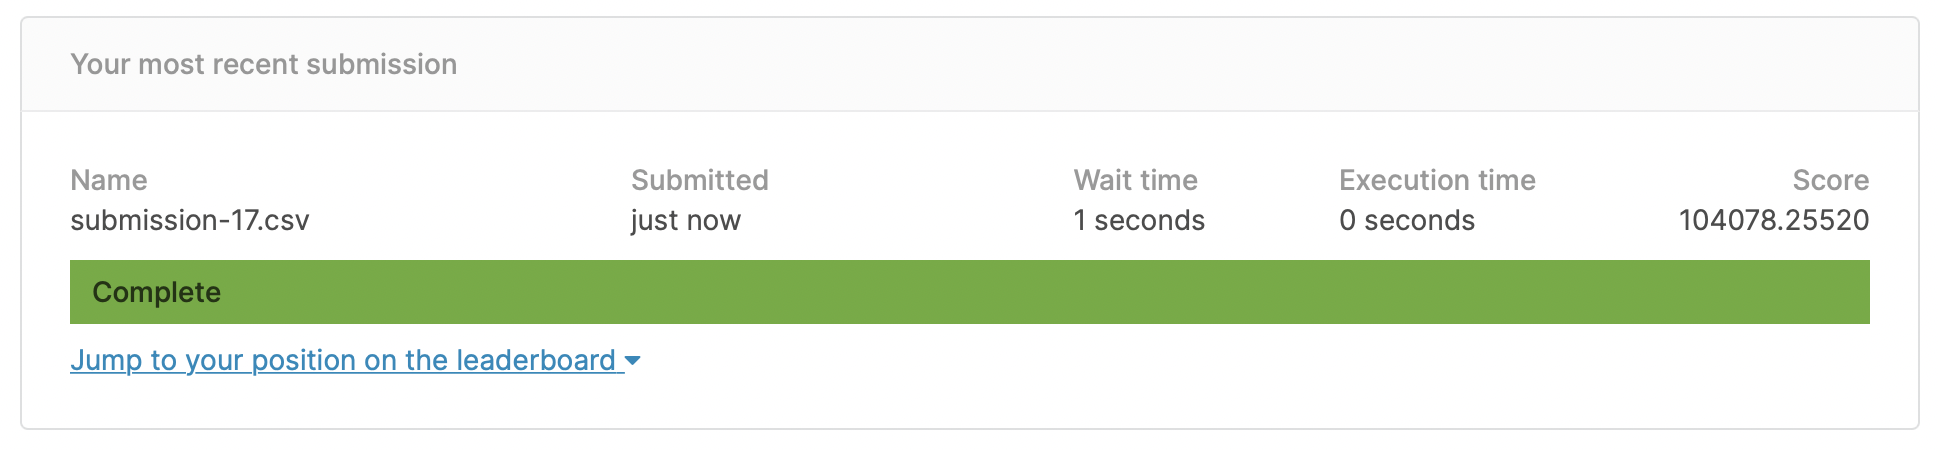